In [261]:
import pandas as pd
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

In [262]:
def reg_graph_subplot(x, y, data, sct_size=None, s=10, title='', legend_visibility=True, legend_title='', xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False, reg_from_start=False, offset_txt_x=0.15, offset_txt_y=2.25, num_rows=1, num_cols=1, subplot_num=1, axes=None):
    # x = eixo x do gráfico
    # y = eixo y do gráfico
    # data = dataframe origem dos dados que representam x e y
    # sct_size = tamanho do scatter no gráfico BASEADO em uma coluna do dataframe
    # s = tamanho do scatter no gráfico BASEADO em um NUMERO
    # title = título do gráfico
    # legend_visibility = visibilidade da legenda
    # legend_title = título da legenda
    # xlabel = título do eixo x
    # ylabel = titulo do eixo y
    # offset_txt_x = deslocamento do texto da função no eixo x
    # offset_txt_y = deslocamento do texto da função no eixo y
    # num_rows = número de linhas de subplots
    # num_cols = número de colunas de subplots
    # subplot_num = número do subplot atual
    # axes = array de eixos para os subplots

    sns.set_style('darkgrid')

    if axes is None:
        f, ax = plt.subplots(num_rows, num_cols, figsize=(12, 5))
    else:
        ax = axes[subplot_num - 1]

    sns.scatterplot(x=data[x], y=data[y], data=data, size=sct_size, s=s, ax=ax)

    rng = np.random.default_rng(1234)  # seed para valores aleatórios
    lr = LinearRegression(fit_intercept=fit_intercept)
    fitted_reg = lr.fit(data[[x]], data[[y]])

    if not fit_intercept:
        fitted_reg.intercept_ = [fitted_reg.intercept_]  # Prevenindo erros

    r2_score = fitted_reg.score(data[[x]], data[[y]])  # R² Score
    x_reg_line = rng.uniform(data[x].min(), data[x].max(), size=100)  # gerando valores entre os valores do scatterplot para criar a reta
    y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0]  # função y=ax + b para representar a reta criada

    if reg_from_start:

        if (data[x].min() < 0) and (abs(data[x].min()) > data[y].max()):  # Para valores data[x] negativos

            x_reg_line = rng.uniform(data[x].min() * 2, 0.0, size=10000)  # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0

        elif (data[y].min() < 0) and (abs(data[y].min()) > data[x].max()):  # Para valores data[y] negativos

            x_reg_line = rng.uniform(data[y].min() * 2, 0.0, size=10000)  # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0

        elif (data[x].max() > data[y].max()):

            x_reg_line = rng.uniform(0.0, data[x].max() * 2, size=10000)

        else:

            x_reg_line = rng.uniform(0.0, data[y].max() * 2, size=10000)

        y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0]  # função y=ax + b para representar a reta criada

    text_coord_x = data[x].max() - data[x].max() * offset_txt_x  # eixo x do texto

    ax.text(text_coord_x, offset_txt_y, f'Y={round(fitted_reg.coef_[0][0], 4)}x + {round(fitted_reg.intercept_[0], 4)}',
            fontsize=12, ha='center', va='center', color='blue')  # Texto da reta Azul
    ax.text(text_coord_x, offset_txt_y - (offset_txt_y * 0.3), f'R²:{round(r2_score, 4)}', fontsize=12, ha='center',
            va='center', color='blue')  # Texto r²

    ax.set_ylim((0, (data[y].max() + (data[y].max() / 2))))  # tamanho limite do plot no eixo y
    ax.set_xlim((0, data[x].max() + data[x].max() / 2))  # tamanho limite do plot no eixo x
    ax.plot(x_reg_line, y_reg_line[0])  # reta de regressão

    if ativar_grafico_yx:
        y_x = rng.uniform(0, 1000, size=1000)  # gerando 1000 valores aleatórios
        ax.plot(y_x, y_x, 'k--')  # reta y=x

    if legend_title:
        ax.legend(title=legend_title, loc='upper left').set_visible(legend_visibility)  # legenda no canto superior esquerdo

    ax.set_title(title)  # Título do gráfico
    ax.set_xlabel(xlabel)  # Título do eixo X
    ax.set_ylabel(ylabel)  # Título do eixo y

    return ax

In [263]:
def date_parser(date):
    return pd.to_datetime(f"{int(date[1:5])}-{int(date[5:])}",format="%Y-%j")

google_npp = pd.read_csv('./googleEarth/GPP_NPP_GOOGLE.csv',parse_dates=['system:time_start'],index_col=['system:time_start'])
google_gpp = pd.read_csv('./googleEarth/GPP_8_DIAS.csv',parse_dates=['system:time_start'],index_col=['system:time_start'])
modis_NPP = pd.read_csv('./DadosNPPSatelite/filtered_scaled_Npp_500m.csv',header=None)
modis_GPP = pd.read_csv('./DadosGPPSatelite/filtered_scaled_Gpp_500m.csv',na_values='F',header=None,parse_dates=[2],index_col=[2],date_parser=date_parser)

In [264]:
google_data = google_npp.apply(lambda x:x.str.replace(',','.'),axis=1).loc[:,'Gpp':'Npp'].copy()
tower_NPP = modis_NPP[[149]].copy()

In [265]:
modis_GPP_torre = modis_GPP.loc['2021-01-01':'2021-12-27'][149] * 100 # Multiplicação para melhorar a visualização do gráfico
google_gpp_torre = google_gpp.loc['2021-01-01':'2021-12-27'][['Gpp']]

# GPP Comparação

In [266]:
gpp_dataframe = {
    'Modis Tower GPP': modis_GPP_torre.values,
    'Google Tower GPP': google_gpp_torre['Gpp'].values,
}
gpp_dataframe = pd.DataFrame(gpp_dataframe,index=google_gpp_torre.index)
gpp_dataframe = gpp_dataframe.dropna()
gpp_dataframe.corr()

,Modis Tower GPP,Google Tower GPP
Modis Tower GPP,1.000000,0.425286
Google Tower GPP,0.425286,1.000000


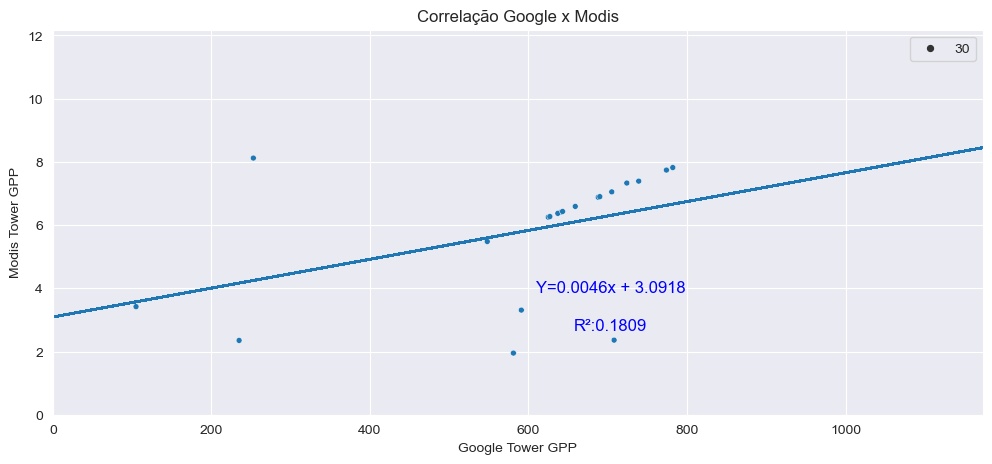

<Figure size 300x500 with 0 Axes>

In [267]:
eixo_x = 'Google Tower GPP'
eixo_y = 'Modis Tower GPP'
data = gpp_dataframe
xlabel = "Google Tower GPP"
ylabel = "Modis Tower GPP"

title = 'Correlação Google x Modis'

reg_graph_subplot(eixo_x,eixo_y,sct_size=30,data=data,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,reg_from_start=True,offset_txt_x=0.1,offset_txt_y=4)
plt.figure(figsize=(3,5))
plt.show()

In [268]:
(gpp_dataframe['Modis Tower GPP'] / 100).mean()

0.058210000000000005

In [269]:
(gpp_dataframe['Google Tower GPP'] / 10000).mean()

0.05977500000000001

In [276]:
Modis = gpp_dataframe['Modis Tower GPP'] / 100 # voltar pra escala original
Google = gpp_dataframe['Google Tower GPP'] / 10000 # Adaptar a mesma escala
t_statistic, p_value = stats.ttest_ind(Modis, Google)

print("Estatística t:", t_statistic)
print("Valor-p:", p_value)

# Interpretando o resultado
alpha = 0.05  # Nível de significância
if p_value < alpha:
    print("Rejeitamos a hipótese nula. Há evidências de diferença significativa entre as séries.")
else:
    print("Não podemos rejeitar a hipótese nula. Não há evidências de diferença significativa entre as séries.")

Estatística t: -0.2582975885976031
Valor-p: 0.7975711423646862
Não podemos rejeitar a hipótese nula. Não há evidências de diferença significativa entre as séries.


# NPP Comparação

In [271]:
npp_dataframe = {
    'Modis Tower NPP': tower_NPP[149].values,
    'Google Tower NPP': google_data['Npp'].values,
}
npp_dataframe = pd.DataFrame(npp_dataframe,index=npp_google.index)
npp_dataframe['Google Tower NPP'] = pd.to_numeric(npp_dataframe['Google Tower NPP'])
npp_dataframe.corr()

,Modis Tower NPP,Google Tower NPP
Modis Tower NPP,1.0,1.0
Google Tower NPP,1.0,1.0


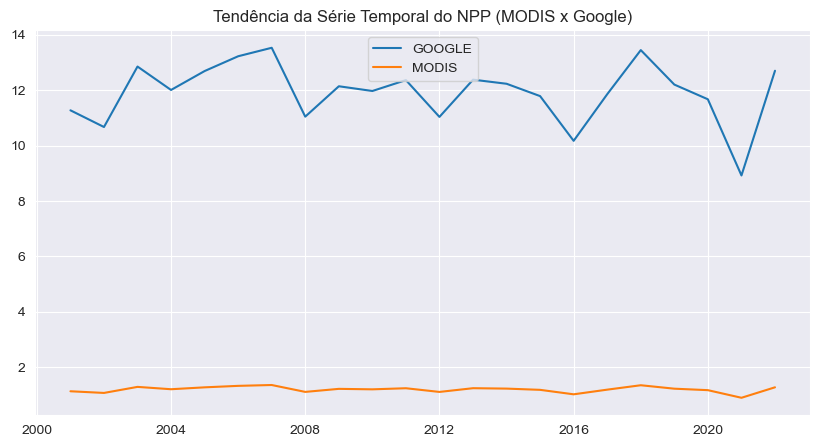

In [274]:
google_decomponsicao = seasonal_decompose(npp_dataframe['Google Tower NPP'])
modis_decomponsicao = seasonal_decompose(npp_dataframe['Modis Tower NPP'])

plt.figure(figsize=(10,5))
plt.plot(google_decomponsicao.trend)
plt.plot(modis_decomponsicao.trend)

plt.title("Tendência da Série Temporal do NPP (MODIS x Google)")
plt.legend(['GOOGLE','MODIS'],loc='upper center').set_visible(True)

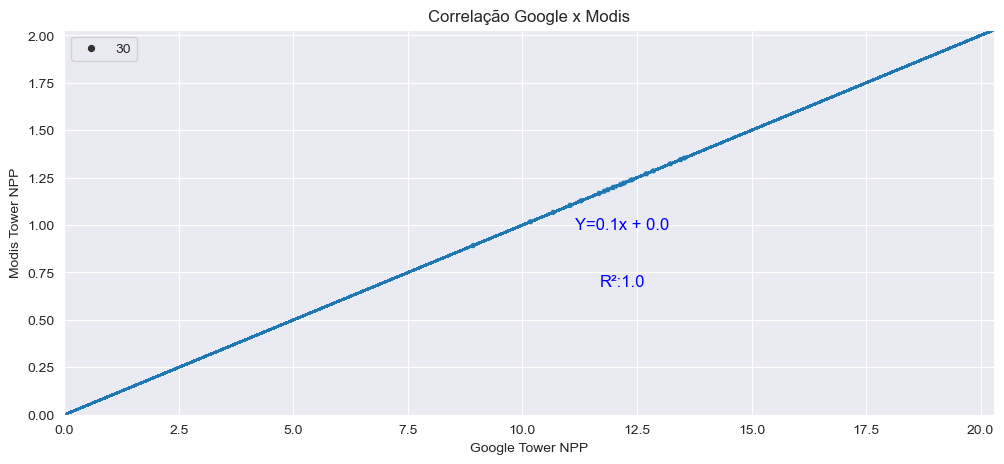

<Figure size 500x500 with 0 Axes>

In [275]:
eixo_x = 'Google Tower NPP'
eixo_y = 'Modis Tower NPP'
data = npp_dataframe
xlabel = "Google Tower NPP"
ylabel = "Modis Tower NPP"

title = 'Correlação Google x Modis'

reg_graph_subplot(eixo_x,eixo_y,sct_size=30,data=data,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,reg_from_start=True,offset_txt_x=0.1,offset_txt_y=1)
plt.figure(figsize=(5,5))
plt.show()

In [37]:
Modis = npp_dataframe['Modis Tower NPP']
Google = npp_dataframe['Google Tower NPP'] / 10
t_statistic, p_value = stats.ttest_ind(Modis, Google)

print("Estatística t:", t_statistic)
print("Valor-p:", p_value)

# Interpretando o resultado
alpha = 0.05  # Nível de significância
if p_value < alpha:
    print("Rejeitamos a hipótese nula. Há evidências de diferença significativa entre as séries.")
else:
    print("Não podemos rejeitar a hipótese nula. Não há evidências de diferença significativa entre as séries.")

Estatística t: 0.0
Valor-p: 1.0
Não podemos rejeitar a hipótese nula. Não há evidências de diferença significativa entre as séries.
